<a href="https://colab.research.google.com/github/jisuseo/forecast_kimsasia/blob/main/forecast_kimsasia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
dataset_pur = pd.read_csv("/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_purchase.csv", encoding = 'latin-1',  sep=';', skipinitialspace=True)
dataset_dem = pd.read_csv("/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_demand.csv", encoding = 'latin-1',  sep=';', skipinitialspace=True)

<ipython-input-3-2e0aa5e96b50>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_dem = pd.read_csv("/content/drive/MyDrive/#IT/forecast_kimsasia/data/20.10.2022-03.12.2024_demand.csv", encoding = 'latin-1',  sep=';', skipinitialspace=True)


In [4]:
dataset_pur.head()

,BDaAU,BDaRG,Artikel,Bezeichnung,Partien.Nummer,haltbar,EZMenge,Menge,EK,Preis,...,ErstelltUm,ErstelltVon,HaltbarBis,Lieferant,LfdNr,Name,Lieferanten.Name,Lieferanten.PLZ,Lieferanten.Ort,Lieferanten.Land
0,NaN,21.10.2022,K-010018,Ojingeo Champong Ramyun 20X124g,NaN,NaN,300.0,6.0,"0,79","0,70",...,08:30,JY,NaN,72316,1,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
1,NaN,21.10.2022,K-010019,Ansung Tang Myun 20X125G,NaN,NaN,400.0,8.0,"0,56","0,54",...,08:30,JY,NaN,72316,2,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
2,NaN,21.10.2022,K-01020,Veggie Soon Cup 12x67g,NaN,NaN,100.0,1.2,"0,71","0,66",...,08:30,JY,NaN,72316,3,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
3,NaN,21.10.2022,K-01006,Veggie Ramyun Soon Export 20x112g,NaN,NaN,400.0,8.0,"0,64","0,61",...,08:30,JY,NaN,72316,4,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
4,NaN,21.10.2022,K-0114,Potato Noodle Soup 20x100g,NaN,NaN,300.0,6.0,"0,64","0,61",...,08:30,JY,NaN,72316,5,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR


In [5]:
dataset_pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BDaAU             4277 non-null   object 
 1   BDaRG             2811 non-null   object 
 2   Artikel           12800 non-null  object 
 3   Bezeichnung       12799 non-null  object 
 4   Partien.Nummer    12593 non-null  float64
 5   haltbar           12455 non-null  object 
 6   EZMenge           12794 non-null  float64
 7   Menge             12796 non-null  float64
 8   EK                12138 non-null  object 
 9   Preis             12658 non-null  object 
 10  Gesamt            12754 non-null  object 
 11  St                12792 non-null  float64
 12  ErstelltAm        12800 non-null  object 
 13  ErstelltUm        12800 non-null  object 
 14  ErstelltVon       12800 non-null  object 
 15  HaltbarBis        10839 non-null  object 
 16  Lieferant         12800 non-null  int64 

In [66]:
dataset_pur.head(20)

,BDaAU,BDaRG,Artikel,Bezeichnung,Partien.Nummer,haltbar,EZMenge,Menge,EK,Preis,...,ErstelltUm,ErstelltVon,HaltbarBis,Lieferant,LfdNr,Name,Lieferanten.Name,Lieferanten.PLZ,Lieferanten.Ort,Lieferanten.Land
0,2022-10-24,2022-10-21,K-010018,Ojingeo Champong Ramyun 20X124g,NaN,NaN,300.0,6.000,"0,79","0,70",...,08:30,JY,NaN,72316,1,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
1,2022-10-24,2022-10-21,K-010019,Ansung Tang Myun 20X125G,NaN,NaN,400.0,8.000,"0,56","0,54",...,08:30,JY,NaN,72316,2,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
2,2022-10-24,2022-10-21,K-01020,Veggie Soon Cup 12x67g,NaN,NaN,100.0,1.200,"0,71","0,66",...,08:30,JY,NaN,72316,3,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
3,2022-10-24,2022-10-21,K-01006,Veggie Ramyun Soon Export 20x112g,NaN,NaN,400.0,8.000,"0,64","0,61",...,08:30,JY,NaN,72316,4,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
4,2022-10-24,2022-10-21,K-0114,Potato Noodle Soup 20x100g,NaN,NaN,300.0,6.000,"0,64","0,61",...,08:30,JY,NaN,72316,5,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
5,2022-10-24,2022-10-21,K-01021,Kimchi Cup Noodle 12x75g,NaN,NaN,100.0,1.200,"0,77","0,66",...,08:30,JY,NaN,72316,6,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
6,2022-10-24,2022-10-21,K-01002,Shin Ramyun Multi Export 8x5x120g,NaN,NaN,500.0,20.000,"0,64","0,61",...,08:30,JY,NaN,72316,7,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
7,2022-10-24,2022-10-21,K-01005,Veggie Soon Instant Noodle 40x112g,NaN,NaN,200.0,8.000,"0,64","0,61",...,08:30,JY,NaN,72316,8,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
8,2022-10-24,2022-10-21,K-010014,Chapagetti Chajangmyun,NaN,NaN,1.0,20.000,"0,68","0,65",...,08:30,JY,NaN,72316,9,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR
9,2022-10-24,2022-10-21,K-02112,Honey Twist Snack export 20x75G,NaN,NaN,50.0,1.000,"0,75","0,68",...,08:30,JY,NaN,72316,10,"Nongshim Co., Ltd.","Nongshim Co., Ltd.",NaN,"Seoul, Korea",KR


In [7]:
# 결측값 처리
# 데이터 타입 변환
# 불필요한 열 제거
# 중복 데이터 확인 및 제거
# 데이터 표준화

In [27]:
#결측값 확인
total_rows = len(dataset_pur)
missing_values_summary['MissingPercentage'] = (
    missing_values_summary['MissingCount'] / len(dataset_pur) * 100
)


In [28]:
print("총 열의 개수 :", total_rows)
missing_values_summary

총 열의 개수 : 12800


,Column,MissingCount,MissingPercentage
0,BDaAU,8523,66.585938
1,BDaRG,9989,78.039062
2,Artikel,0,0.000000
3,Bezeichnung,1,0.007812
4,Partien.Nummer,207,1.617187
5,haltbar,345,2.695312
6,EZMenge,6,0.046875
7,Menge,4,0.031250
8,EK,662,5.171875
9,Preis,142,1.109375


In [29]:
# 날짜 열을 datetime 형식으로 변환 (BDaAU와 BDaRG)
dataset_pur['BDaAU'] = pd.to_datetime(dataset_pur['BDaAU'], format='%d.%m.%Y', errors='coerce')
dataset_pur['BDaRG'] = pd.to_datetime(dataset_pur['BDaRG'], format='%d.%m.%Y', errors='coerce')

print(dataset_pur[['BDaAU', 'BDaRG']].head())



  BDaAU      BDaRG
0   NaT 2022-10-21
1   NaT 2022-10-21
2   NaT 2022-10-21
3   NaT 2022-10-21
4   NaT 2022-10-21


In [34]:
# 상단과 하단에서 존재하는 값을 추출
upper_bda_au = dataset_pur['BDaAU'].iloc[:len(dataset_pur)//2].dropna()
lower_bda_au = dataset_pur['BDaAU'].iloc[len(dataset_pur)//2:].dropna()

upper_bda_rg = dataset_pur['BDaRG'].iloc[:len(dataset_pur)//2].dropna()
lower_bda_rg = dataset_pur['BDaRG'].iloc[len(dataset_pur)//2:].dropna()

# 상단과 하단 대표값 계산
upper_date_au = upper_bda_au.mean() if not upper_bda_au.empty else None
lower_date_au = lower_bda_au.mean() if not lower_bda_au.empty else None

upper_date_rg = upper_bda_rg.mean() if not upper_bda_rg.empty else None
lower_date_rg = lower_bda_rg.mean() if not lower_bda_rg.empty else None

# 결측값을 채우는 함수 정의
def fill_bda_with_existing_values(row, column, upper_date, lower_date):
    if pd.isnull(row[column]):  # 결측값인 경우
        if row.name < len(dataset_pur) // 2:  # 상단 행
            return upper_date
        else:  # 하단 행
            return lower_date
    return row[column]  # 원래 값 유지

# 각 열의 결측값 채우기
dataset_pur['BDaAU'] = dataset_pur.apply(lambda row: fill_bda_with_existing_values(row, 'BDaAU', upper_date_au, lower_date_au), axis=1)
dataset_pur['BDaRG'] = dataset_pur.apply(lambda row: fill_bda_with_existing_values(row, 'BDaRG', upper_date_rg, lower_date_rg), axis=1)

# 결과 확인
dataset_pur[['BDaAU', 'BDaRG']].isnull().sum()



,0
BDaAU,0
BDaRG,0


In [37]:
# 날짜만 추출한 데이터프레임 출력
print(dataset_pur[['BDaAU', 'BDaRG']].head().applymap(lambda x: x.strftime('%Y-%m-%d')))
print(dataset_pur[['BDaAU', 'BDaRG']].sample(10).applymap(lambda x: x.strftime('%Y-%m-%d')))


        BDaAU       BDaRG
0  2022-10-24  2022-10-21
1  2022-10-24  2022-10-21
2  2022-10-24  2022-10-21
3  2022-10-24  2022-10-21
4  2022-10-24  2022-10-21
            BDaAU       BDaRG
9427   2024-04-04  2024-03-28
11240  2024-07-24  2024-03-28
7267   2023-09-06  2024-03-28
11143  2024-06-20  2024-03-28
12060  2024-10-04  2024-03-28
8475   2024-01-10  2024-03-28
5596   2022-10-24  2023-05-24
3430   2022-10-24  2023-01-18
5746   2022-10-24  2023-01-18
7928   2023-11-13  2024-03-28


<ipython-input-37-5f67181459fd>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(dataset_pur[['BDaAU', 'BDaRG']].head().applymap(lambda x: x.strftime('%Y-%m-%d')))
<ipython-input-37-5f67181459fd>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(dataset_pur[['BDaAU', 'BDaRG']].sample(10).applymap(lambda x: x.strftime('%Y-%m-%d')))


데이터 탐색
목표 데이터의 주요 특징 파악

데이터의 분포, 패턴, 이상값 파악

통계값 확인
특정 열의 값 분포 시각화
날짜를 기준으로 한 트렌드 분석


1. 기본 통계 확인
- 전반적인 요약 통계량 (ean, std, min, max)
- 숫자형 데이터와 날짜 데이터 중심으로 탐색

2. 결측값 재확인
- 결측값이 얼마나 남았는지 재확인

3. 열별 데이터 분포 파악
- 주요 숫자형 열 Menge, Preis, Gesamt 분포 시각화
- 날짜 열 (BDaAU, BDaRG) 범위를 확인

4. 데이터 간 관계 분석
- 구매 수량(Menge)과 총 금액(Gesamt)의 상관관계분석
- 특정 공급자별 구매량 분석

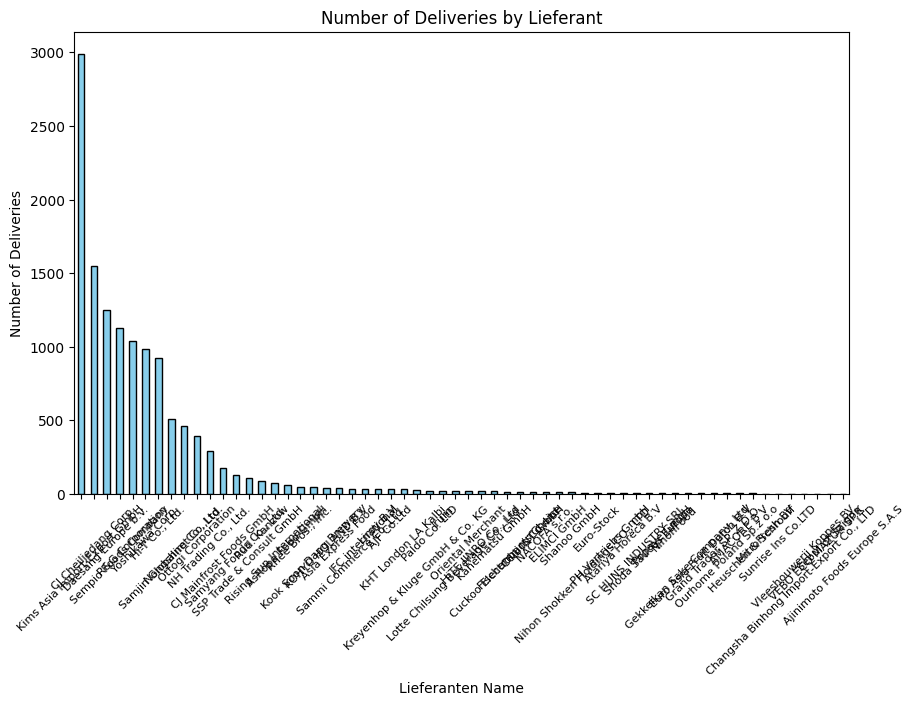

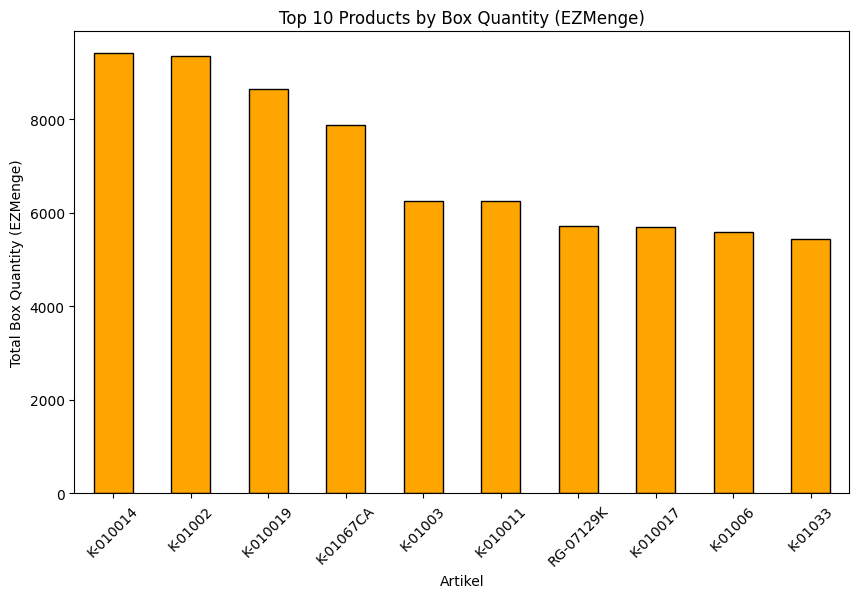

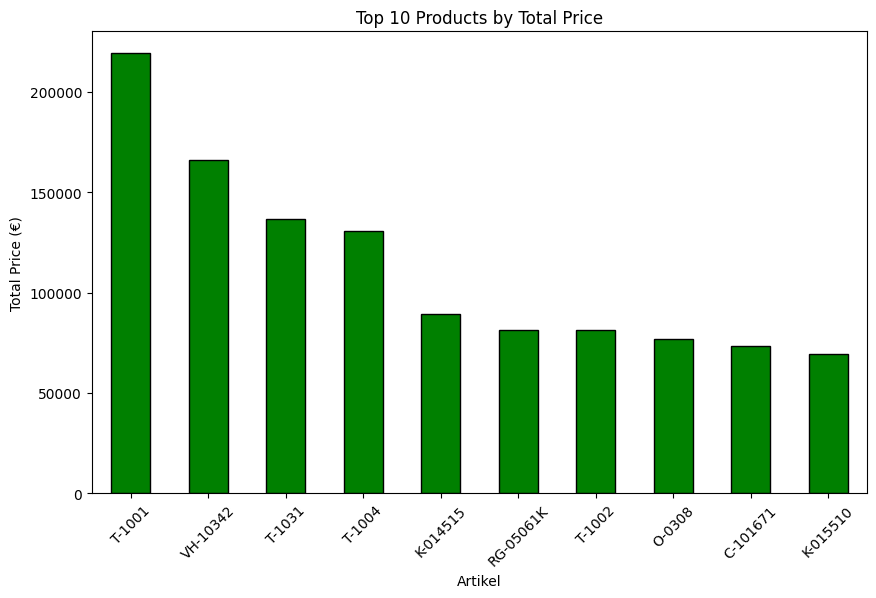

기본 통계량:
                    count unique                           top  freq  \
BDaAU               12800    NaN                           NaN   NaN   
BDaRG               12800    NaN                           NaN   NaN   
Artikel             12800   2447                       A-10005    37   
Bezeichnung         12799   2588                 Paprika Paste   136   
Partien.Nummer    12593.0    NaN                           NaN   NaN   
haltbar             12455   1610                    31.12.2030   278   
EZMenge           12794.0    NaN                           NaN   NaN   
Menge             12796.0    NaN                           NaN   NaN   
EK                12138.0    NaN                           NaN   NaN   
Preis               12658   1422                          0,89   102   
Gesamt              12754   4977                        936,00    42   
St                12792.0    NaN                           NaN   NaN   
ErstelltAm          12800    398                    21.1

In [71]:
# 1. 데이터의 기본 통계 확인
basic_stats = dataset_pur.describe(include='all').transpose()

# 2. 숫자형 열의 분포를 시각화 (히스토그램)
numeric_columns = dataset_pur.select_dtypes(include=['float64', 'int64']).columns
numeric_stats = dataset_pur[numeric_columns]

# 히스토그램 그리기
# 1. Lieferant별 입고 횟수

lieferant_counts = dataset_pur['Lieferanten.Name'].value_counts()

plt.figure(figsize=(10, 6))
lieferant_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Deliveries by Lieferant')
plt.xlabel('Lieferanten Name')
plt.ylabel('Number of Deliveries')
plt.xticks(rotation=45, fontsize=8)  # 폰트 크기 설정
plt.show()


# 2. Artikel과 EZMenge
artikel_ezmenge = dataset_pur.groupby('Artikel')['EZMenge'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
artikel_ezmenge.head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Products by Box Quantity (EZMenge)')
plt.xlabel('Artikel')
plt.ylabel('Total Box Quantity (EZMenge)')
plt.xticks(rotation=45)
plt.show()

# 3. Artikel과 가격
# Menge * EK 계산을 위해 EK를 숫자형으로 변환
dataset_pur['EK'] = dataset_pur['EK'].astype(str).str.replace(',', '.', regex=False)  # 문자열로 변환 후 쉼표를 점으로 변경
dataset_pur['EK'] = pd.to_numeric(dataset_pur['EK'], errors='coerce')  # 숫자형으로 변환, 변환 불가한 값은 NaN 처리

# Total Price 계산
dataset_pur['Total Price'] = dataset_pur['Menge'] * dataset_pur['EK']

# Artikel별 총 금액 계산
artikel_total_price = dataset_pur.groupby('Artikel')['Total Price'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
artikel_total_price.head(10).plot(kind='bar', color='green', edgecolor='black')
plt.title('Top 10 Products by Total Price')
plt.xlabel('Artikel')
plt.ylabel('Total Price (€)')
plt.xticks(rotation=45)
plt.show()



# 기본 통계량 저장 또는 출력
print("기본 통계량:")
print(basic_stats)


주문부터 도착까지 걸린 시간 통계 요약:
count    12800.000000
mean        27.237188
std        103.716608
min       -276.000000
25%        -32.000000
50%         86.000000
75%         86.000000
max        277.000000
Name: DeliveryTime, dtype: float64

음수 값이 존재하는 데이터:
           BDaAU                         BDaRG  DeliveryTime
0     2022-10-24 2022-10-21 00:00:00.000000000            -3
1     2022-10-24 2022-10-21 00:00:00.000000000            -3
2     2022-10-24 2022-10-21 00:00:00.000000000            -3
3     2022-10-24 2022-10-21 00:00:00.000000000            -3
4     2022-10-24 2022-10-21 00:00:00.000000000            -3
...          ...                           ...           ...
12793 2024-11-22 2024-03-28 02:55:22.033898496          -239
12794 2024-11-22 2024-03-28 02:55:22.033898496          -239
12795 2024-11-22 2024-03-28 02:55:22.033898496          -239
12796 2024-11-22 2024-03-28 02:55:22.033898496          -239
12797 2024-11-22 2024-03-28 02:55:22.033898496          -239

[4222 rows x 3 c

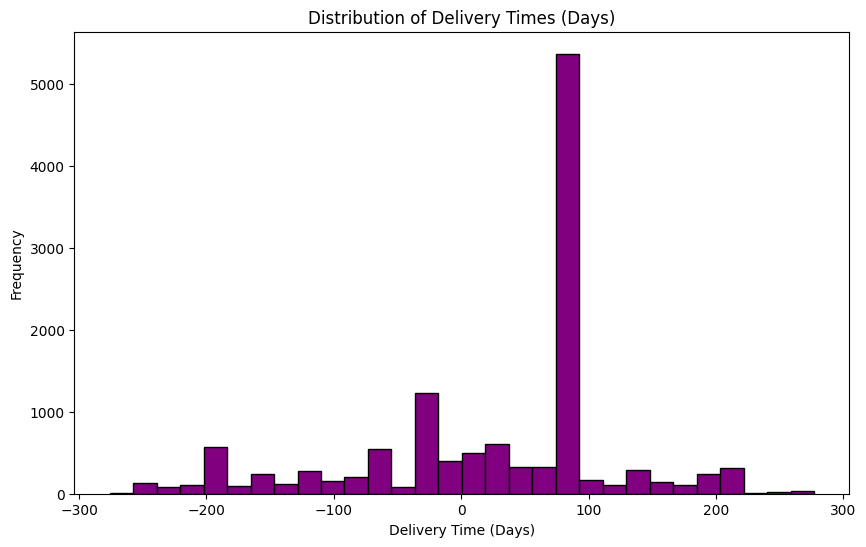

In [72]:
# 1. 시간 차이 계산
dataset_pur['DeliveryTime'] = (dataset_pur['BDaRG'] - dataset_pur['BDaAU']).dt.days

# 2. 통계 요약
delivery_time_stats = dataset_pur['DeliveryTime'].describe()

print("주문부터 도착까지 걸린 시간 통계 요약:")
print(delivery_time_stats)

# 음수 값 확인 (데이터 문제 탐색)
negative_delivery_time = dataset_pur[dataset_pur['DeliveryTime'] < 0]
print("\n음수 값이 존재하는 데이터:")
print(negative_delivery_time[['BDaAU', 'BDaRG', 'DeliveryTime']])

# 3. 소요 시간 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(dataset_pur['DeliveryTime'].dropna(), bins=30, edgecolor='black', color='purple')
plt.title('Distribution of Delivery Times (Days)')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.show()


In [75]:
# 분석 결과를 텍스트로 작성
report = """
### 컨테이너 주문-도착 시간 분석 보고서

#### 분석 개요
본 분석은 `BDaAU`(컨테이너 주문일)와 `BDaRG`(컨테이너 도착일) 간의 시간차를 계산하여, 컨테이너 주문부터 도착까지 평균적으로 소요되는 기간을 분석하였습니다.

#### 주요 결과
1. 평균 소요 시간: {:.2f}일
2. 최소 소요 시간: {}일
3. 최대 소요 시간: {}일
4. 분석된 총 컨테이너 수: {}개
5. 데이터 오류(음수 값) 사례:
   - {}개의 데이터에서 주문일이 도착일보다 이후로 기록된 오류가 발견되었습니다.

#### 시각적 요약
소요 시간의 분포를 시각화한 히스토그램을 통해, 대부분의 컨테이너는 {:.2f}일에서 {:.2f}일 사이에 도착했으며, 일부는 평균보다 긴 소요 시간을 기록했습니다.
""".format(
    delivery_time_stats['mean'],
    delivery_time_stats['min'],
    delivery_time_stats['max'],
    len(dataset_pur),
    len(negative_delivery_time),
    delivery_time_stats['25%'],
    delivery_time_stats['75%']
)

# 결과를 출력
print(report)



### 컨테이너 주문-도착 시간 분석 보고서

#### 분석 개요
본 분석은 `BDaAU`(컨테이너 주문일)와 `BDaRG`(컨테이너 도착일) 간의 시간차를 계산하여, 컨테이너 주문부터 도착까지 평균적으로 소요되는 기간을 분석하였습니다.

#### 주요 결과
1. 평균 소요 시간: 27.24일
2. 최소 소요 시간: -276.0일
3. 최대 소요 시간: 277.0일
4. 분석된 총 컨테이너 수: 12800개
5. 데이터 오류(음수 값) 사례:
   - 4222개의 데이터에서 주문일이 도착일보다 이후로 기록된 오류가 발견되었습니다.

#### 시각적 요약
소요 시간의 분포를 시각화한 히스토그램을 통해, 대부분의 컨테이너는 -32.00일에서 86.00일 사이에 도착했으며, 일부는 평균보다 긴 소요 시간을 기록했습니다.



주문-도착 시간의 계절적/월별 변화



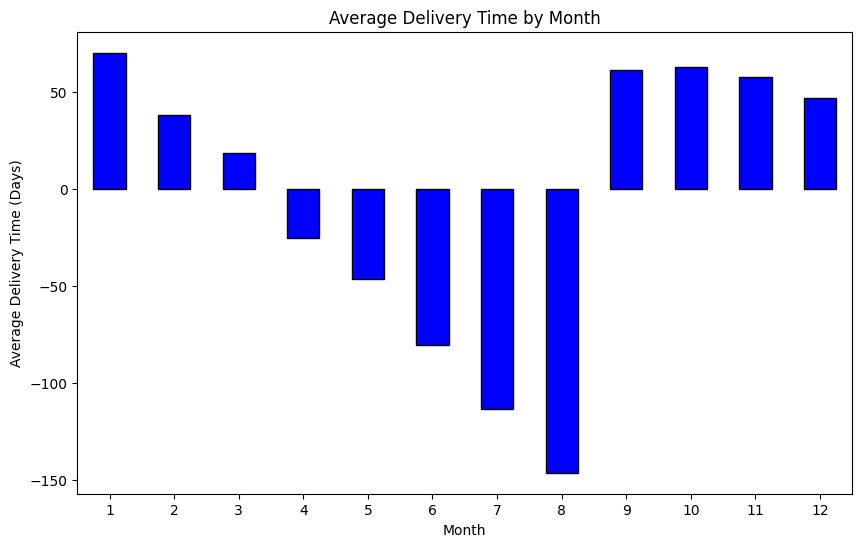

In [80]:
print("주문-도착 시간의 계절적/월별 변화\n")

# 주문-도착 시간 (DeliveryTime) 계산
dataset_pur['DeliveryTime'] = (dataset_pur['BDaRG'] - dataset_pur['BDaAU']).dt.days

# 월별 평균 소요 시간 계산
dataset_pur['OrderMonth'] = dataset_pur['BDaAU'].dt.month
monthly_delivery_time = dataset_pur.groupby('OrderMonth')['DeliveryTime'].mean()

# 월별 평균 소요 시간 시각화
plt.figure(figsize=(10, 6))

monthly_delivery_time.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average Delivery Time by Month')
plt.xlabel('Month')
plt.ylabel('Average Delivery Time (Days)')
plt.xticks(rotation=0)
plt.show()


주분 빈도 분석 



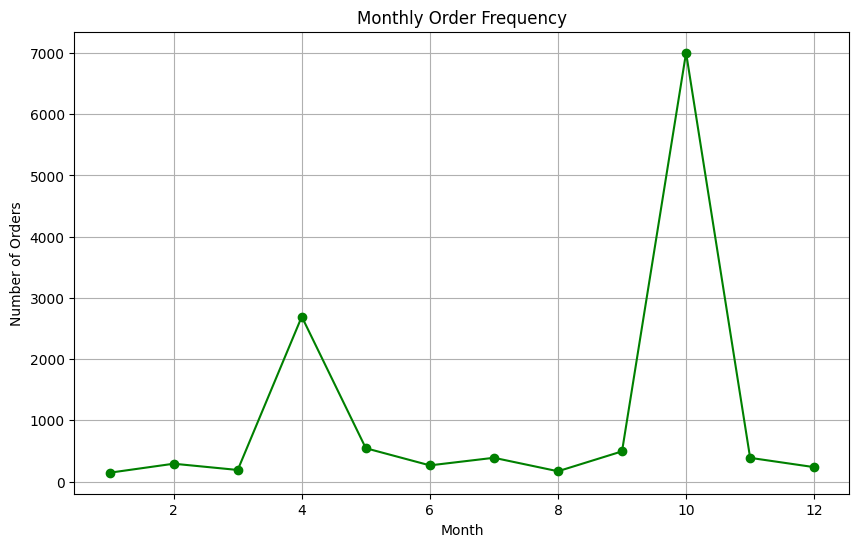

In [81]:
print("주분 빈도 분석 \n")

# 월별 주문 건수 계산
monthly_order_counts = dataset_pur.groupby('OrderMonth')['BDaAU'].count()

# 월별 주문 건수 시각화
plt.figure(figsize=(10, 6))
monthly_order_counts.plot(kind='line', marker='o', color='green')
plt.title('Monthly Order Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


가장 많이 주문된 제품 



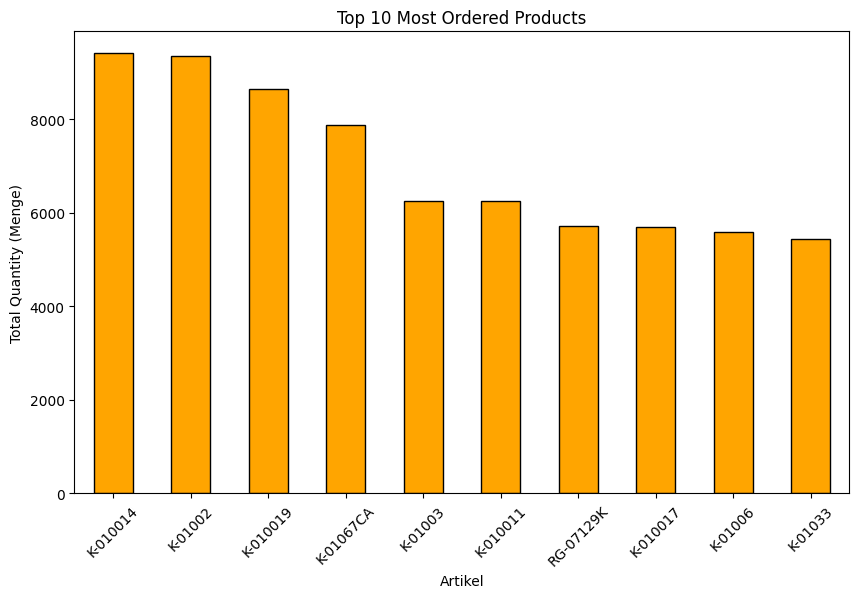

In [83]:
print("가장 많이 주문된 제품 \n")

# 제품별 총 수량 계산
artikel_menge = dataset_pur.groupby('Artikel')['EZMenge'].sum().sort_values(ascending=False)

# 상위 10개 제품 시각화
plt.figure(figsize=(10, 6))
artikel_menge.head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Artikel')
plt.ylabel('Total Quantity (Menge)')
plt.xticks(rotation=45)
plt.show()


제품별 평균 소요 시간 



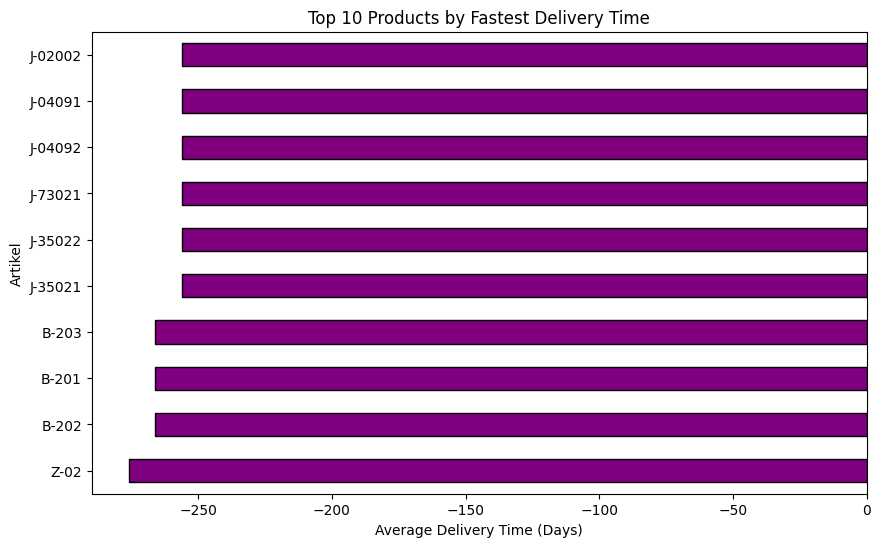

In [84]:
print("제품별 평균 소요 시간 \n")
# 제품별 평균 소요 시간 계산
artikel_avg_delivery_time = dataset_pur.groupby('Artikel')['DeliveryTime'].mean().sort_values()

# 상위 10개 제품 시각화
plt.figure(figsize=(10, 6))
artikel_avg_delivery_time.head(10).plot(kind='barh', color='purple', edgecolor='black')
plt.title('Top 10 Products by Fastest Delivery Time')
plt.xlabel('Average Delivery Time (Days)')
plt.ylabel('Artikel')
plt.show()


공급자별 매출 기여도 



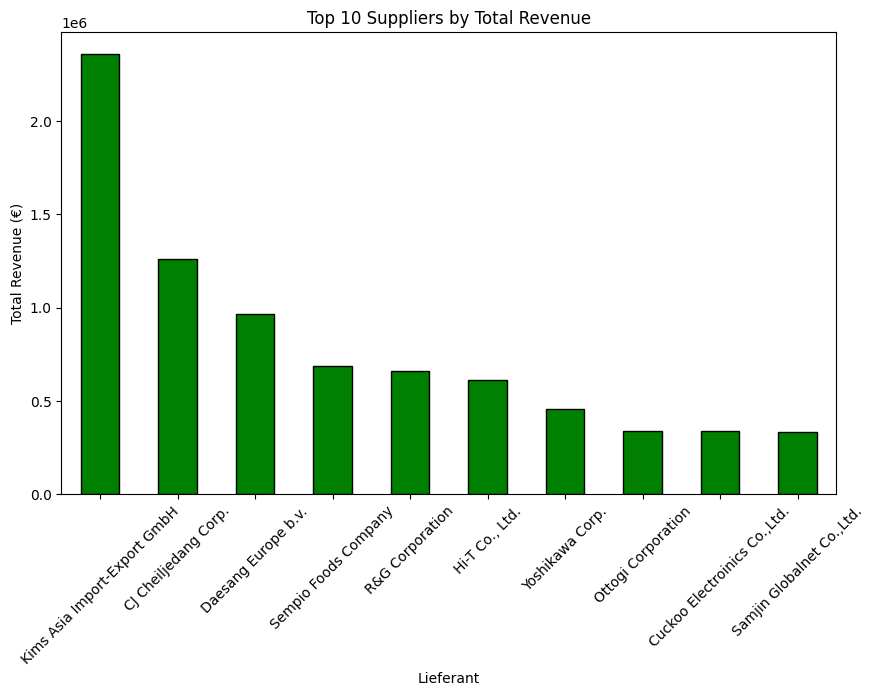

In [85]:
print("공급자별 매출 기여도 \n")

# 공급자별 총 매출 계산
lieferant_total_revenue = dataset_pur.groupby('Lieferanten.Name')['Total Price'].sum().sort_values(ascending=False)

# 상위 10개 공급자 시각화
plt.figure(figsize=(10, 6))
lieferant_total_revenue.head(10).plot(kind='bar', color='green', edgecolor='black')
plt.title('Top 10 Suppliers by Total Revenue')
plt.xlabel('Lieferant')
plt.ylabel('Total Revenue (€)')
plt.xticks(rotation=45)
plt.show()


In [89]:
# 기준 값 확인
delivery_mean = dataset_pur['DeliveryTime'].mean()
delivery_std = dataset_pur['DeliveryTime'].std()
quantity_mean = dataset_pur['Menge'].mean()
quantity_std = dataset_pur['Menge'].std()

print(f"DeliveryTime 평균: {delivery_mean}, 표준편차: {delivery_std}")
print(f"Menge 평균: {quantity_mean}, 표준편차: {quantity_std}")

# 이상치 기준 값
print(f"긴 배송 시간 기준: {delivery_mean + 3 * delivery_std}")
print(f"높은 주문량 기준: {quantity_mean + 3 * quantity_std}")


DeliveryTime 평균: 27.2371875, 표준편차: 103.71660796730612
Menge 평균: 266.8665404814005, 표준편차: 269.4646914385304
긴 배송 시간 기준: 338.38701140191836
높은 주문량 기준: 1075.2606147969916


In [90]:
# 결측값 확인
print("DeliveryTime 결측값 수:", dataset_pur['DeliveryTime'].isnull().sum())
print("Menge 결측값 수:", dataset_pur['Menge'].isnull().sum())


DeliveryTime 결측값 수: 0
Menge 결측값 수: 4


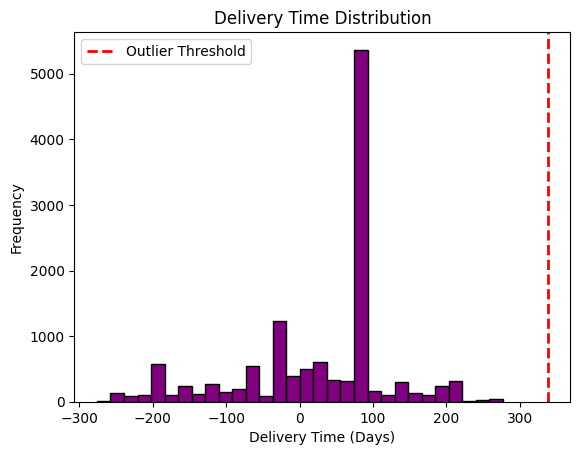

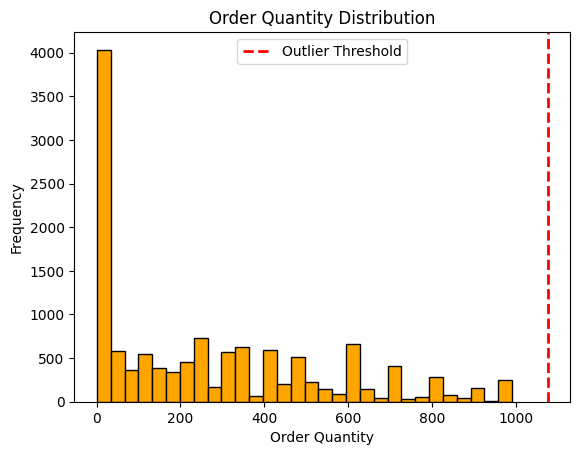

In [91]:
# 배송 시간 분포
plt.hist(dataset_pur['DeliveryTime'].dropna(), bins=30, edgecolor='black', color='purple')
plt.axvline(delivery_mean + 3 * delivery_std, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Delivery Time Distribution')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 주문량 분포
plt.hist(dataset_pur['Menge'].dropna(), bins=30, edgecolor='black', color='orange')
plt.axvline(quantity_mean + 3 * quantity_std, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Order Quantity Distribution')
plt.xlabel('Order Quantity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [63]:
#df_pur = dataset_pur[['BDaRG','Artikel','Bezeichnung', 'haltbar', 'EZMenge','Menge','EK','Lieferanten.Name','Lieferanten.Ort']].copy()
#df_pur
#df_pur.drop(df_pur[df_pur['haltbar'].isna()].index, inplace=True)
#df_pur
#df_pur.info()
#df_pur.head()
#df_pur.isnull().sum()